<a href="https://colab.research.google.com/github/zecojls/SoilSpec4GG_GoogleColab/blob/main/SoilSpec4GG_002_exploring_OSSL_MIR_datasets_R.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Initial setup and packages

## Installing packages
NOTE: the packages must be reinstalled every session

In [ ]:
install.packages("prospectr")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘foreach’, ‘iterators’, ‘mathjaxr’, ‘RcppArmadillo’




## Loading packages

In [ ]:
library(tidyverse)
library(prospectr)

Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”
── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.7
✔ tidyr   1.1.4     ✔ stringr 1.4.0
✔ readr   2.1.1     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

prospectr version 0.2.2 -- 'flawil'

check the github repository at: http://github.com/l-ramirez-lopez/prospectr



# Loading the full OSSL dataset

Loading the full OSSL data from S3 bucket. It takes about 25 secs.

In [ ]:
rm.ossl = readRDS(url("http://s3.us-east-1.wasabisys.com/soilspectroscopy/ossl_import/rm.ossl_v1.rds", "rb"))
dim(rm.ossl)

[1] 152146   2962

## Checking object class and internal data

In [ ]:
str(rm.ossl)

'data.frame':	152146 obs. of  2962 variables:
 $ id.layer_uuid_c                                             : chr  "bd934b2680a2478c8a8ce1913ae79172" "ff03863683a192953930bcb2a874b527" "1fe42f85d1cb818e99d190c80686063a" "8ea0ca98a9a8002ad7e713616d53ed86" ...
 $ id.layer_local_c                                            : chr  "icr006475" "icr006586" "icr007929" "icr008008" ...
 $ sample.doi_idf_c                                            : chr  "10.1016/j.geodrs.2015.06.002" "10.1016/j.geodrs.2015.06.002" "10.1016/j.geodrs.2015.06.002" "10.1016/j.geodrs.2015.06.002" ...
 $ sample.contact.name_utf8_txt                                : chr  "Keith Shepherd" "Keith Shepherd" "Keith Shepherd" "Keith Shepherd" ...
 $ sample.contact.email_ietf_email                             : chr  "afsis.info@africasoils.net" "afsis.info@africasoils.net" "afsis.info@africasoils.net" "afsis.info@africasoils.net" ...
 $ acid.tea_usda4b2_cmolkg                                     : num  NA NA NA NA NA NA 

## Checking available SSLs

In [ ]:
rm.ossl %>%
  distinct(dataset.code_ascii_c)

dataset.code_ascii_c
<chr>
AFSIS1.SSL
AFSIS2.SSL
CAF.SSL
KSSL.SSL
ICRAF.ISRIC
LUCAS.SSL
NEON.SSL


## Checking the number of observations
The MIR spectra contains a **mir** prefix in their columns and ranges from 600 to 4000 cm<sup>-1</sup>.

SOC

In [ ]:
rm.ossl %>%
  group_by(dataset.code_ascii_c) %>%
  filter(!is.na(oc_usda.calc_wpct) & !is.na(scan_mir.600_abs)) %>%
  summarize(n_observations = n()) %>%
  arrange(desc(n_observations))


dataset.code_ascii_c,n_observations
<chr>,<int>
KSSL.SSL,73028
ICRAF.ISRIC,3916
AFSIS2.SSL,781
LUCAS.SSL,605
NEON.SSL,251
CAF.SSL,34


pH H20

In [ ]:
rm.ossl %>%
  group_by(dataset.code_ascii_c) %>%
  filter(!is.na(ph.h2o_usda.4c1_index) & !is.na(scan_mir.600_abs)) %>%
  summarize(n_observations = n()) %>%
  arrange(desc(n_observations))

dataset.code_ascii_c,n_observations
<chr>,<int>
KSSL.SSL,54790
ICRAF.ISRIC,3992
AFSIS1.SSL,1904
AFSIS2.SSL,773
LUCAS.SSL,605
CAF.SSL,534
NEON.SSL,303


Clay

In [ ]:
rm.ossl %>%
  group_by(dataset.code_ascii_c) %>%
  filter(!is.na(clay.tot_usda.3a1_wpct) & !is.na(scan_mir.600_abs)) %>%
  summarize(n_observations = n()) %>%
  arrange(desc(n_observations))

dataset.code_ascii_c,n_observations
<chr>,<int>
KSSL.SSL,51349
ICRAF.ISRIC,3942
LUCAS.SSL,605
CAF.SSL,562
NEON.SSL,293


Looking for the "acidified" term in the dataset

In [ ]:
grep("acidified", names(rm.ossl))

integer(0)

# Exploring the KSSL.SSL

## Selecting the KSSL dataset

It is necessary to include a new column as 'soil layer number' to avoid generating duplicates.

In [113]:
kssl.ssl <- rm.ossl %>%
  filter(dataset.code_ascii_c == "KSSL.SSL") %>%
  group_by(id.layer_uuid_c) %>%
  mutate(id.layer_number = row_number()) %>%
  ungroup()
dim(kssl.ssl)

[1] 74143  2963

## KSLL spectra
The `grep` comand is used to find colums with **mir** prefix, and the first column is also selected as ID.

In [114]:
kssl.ssl.info <- names(kssl.ssl)
paste("There are", length(grep("mir", kssl.ssl.info)), "colums with mir prefix")

kssl.ssl.mir <- kssl.ssl[,c(grep("id.layer_uuid_c", kssl.ssl.info), grep("id.layer_number", kssl.ssl.info), grep("mir", kssl.ssl.info))]
head(kssl.ssl.mir, 5)

[1] "There are 1702 colums with mir prefix"

id.layer_uuid_c,id.layer_number,mirmodel.code_any_c,scan_mir.600_abs,scan_mir.602_abs,scan_mir.604_abs,scan_mir.606_abs,scan_mir.608_abs,scan_mir.610_abs,scan_mir.612_abs,⋯,scan_mir.3982_abs,scan_mir.3984_abs,scan_mir.3986_abs,scan_mir.3988_abs,scan_mir.3990_abs,scan_mir.3992_abs,scan_mir.3994_abs,scan_mir.3996_abs,scan_mir.3998_abs,scan_mir.4000_abs
<chr>,<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
9246444d94f081e3549803b928260f56,1,Bruker_Vertex_70.HTS.XT,1907,1916,1931,1942,1954,1968,1984,⋯,514,513,513,512,512,511,511,510,510,509
9246444d94f081e3549803b928260f56,2,Bruker_Vertex_70.HTS.XT,1574,1584,1597,1611,1627,1643,1657,⋯,195,195,194,194,193,192,192,191,190,189
2387337ba1e0b0249ba90f55b2ba2521,1,Bruker_Vertex_70.HTS.XT,1920,1943,1960,1962,1959,1968,2005,⋯,574,573,573,572,572,571,571,571,570,569
2387337ba1e0b0249ba90f55b2ba2521,2,Bruker_Vertex_70.HTS.XT,1629,1637,1649,1664,1681,1695,1707,⋯,211,210,210,209,209,208,207,206,206,204
fed33392d3a48aa149a87a38b875ba4a,1,Bruker_Vertex_70.HTS.XT,1924,1936,1952,1961,1972,1983,1981,⋯,491,490,489,489,488,488,488,487,487,487


In [115]:
wavenumbers <- seq(600, 4000, by = 2)
names(kssl.ssl.mir)[grep("mir", names(kssl.ssl.mir))] <- c("mirmodel.code_any_c", wavenumbers)
head(kssl.ssl.mir, 5)

id.layer_uuid_c,id.layer_number,mirmodel.code_any_c,600,602,604,606,608,610,612,⋯,3982,3984,3986,3988,3990,3992,3994,3996,3998,4000
<chr>,<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
9246444d94f081e3549803b928260f56,1,Bruker_Vertex_70.HTS.XT,1907,1916,1931,1942,1954,1968,1984,⋯,514,513,513,512,512,511,511,510,510,509
9246444d94f081e3549803b928260f56,2,Bruker_Vertex_70.HTS.XT,1574,1584,1597,1611,1627,1643,1657,⋯,195,195,194,194,193,192,192,191,190,189
2387337ba1e0b0249ba90f55b2ba2521,1,Bruker_Vertex_70.HTS.XT,1920,1943,1960,1962,1959,1968,2005,⋯,574,573,573,572,572,571,571,571,570,569
2387337ba1e0b0249ba90f55b2ba2521,2,Bruker_Vertex_70.HTS.XT,1629,1637,1649,1664,1681,1695,1707,⋯,211,210,210,209,209,208,207,206,206,204
fed33392d3a48aa149a87a38b875ba4a,1,Bruker_Vertex_70.HTS.XT,1924,1936,1952,1961,1972,1983,1981,⋯,491,490,489,489,488,488,488,487,487,487


## Target variable
Selecting the target variable, i.e. Soil Organic Carbon

In [117]:
kssl.ssl.oc <- kssl.ssl[,c(
  grep("id.layer_uuid_c", kssl.ssl.info),
  grep("id.layer_number", kssl.ssl.info),
  grep("oc_usda.calc_wpct", kssl.ssl.info))]
head(kssl.ssl.oc, 5)

id.layer_uuid_c,id.layer_number,oc_usda.calc_wpct
<chr>,<int>,<dbl>
9246444d94f081e3549803b928260f56,1,NA
9246444d94f081e3549803b928260f56,2,NA
2387337ba1e0b0249ba90f55b2ba2521,1,NA
2387337ba1e0b0249ba90f55b2ba2521,2,NA
fed33392d3a48aa149a87a38b875ba4a,1,NA


## Statistical summary
Exploratory data analysis

In [91]:
kssl.ssl.oc %>%
  summary()

 id.layer_local_c   layer.lower.depth_usda_cm oc_usda.calc_wpct
 Length:74143       Min.   :   0.00           Min.   : 0.0000  
 Class :character   1st Qu.:  17.00           1st Qu.: 0.3448  
 Mode  :character   Median :  47.00           Median : 1.0200  
                    Mean   :  62.95           Mean   : 4.8792  
                    3rd Qu.:  95.00           3rd Qu.: 2.7800  
                    Max.   :1783.00           Max.   :78.4500  
                    NA's   :3307              NA's   :1058     

## Summary plots
Density plot

Warning message:
“Removed 1058 rows containing non-finite values (stat_density).”


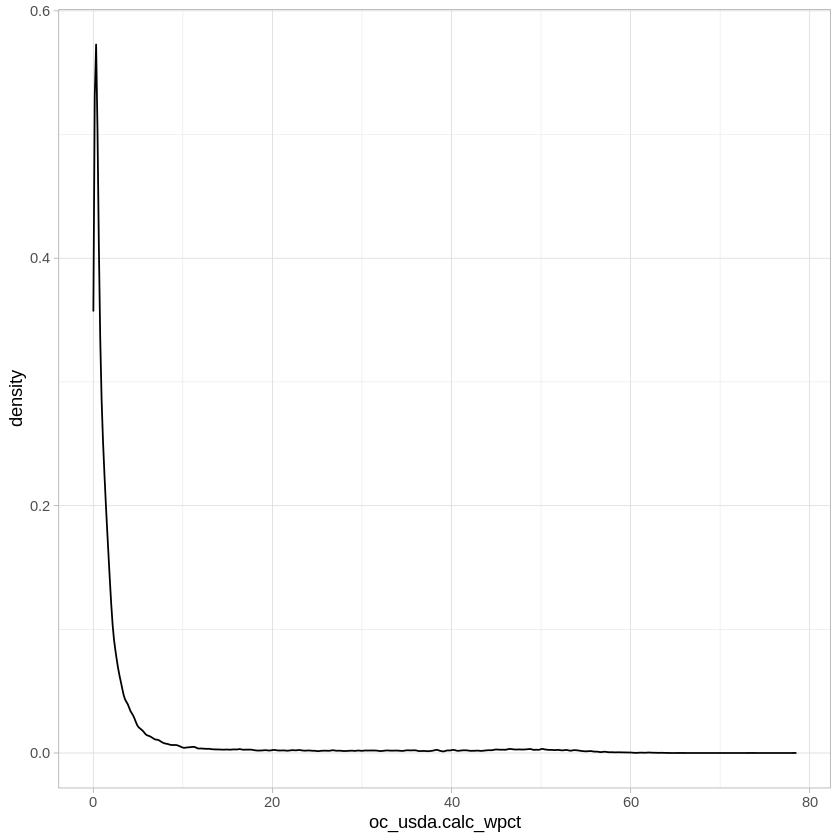

In [93]:
ggplot(kssl.ssl.oc) +
  geom_density(aes(x = oc_usda.calc_wpct)) +
  theme_light()

Density plot with the logarithm to the base 2

Warning message:
“Removed 1126 rows containing non-finite values (stat_density).”


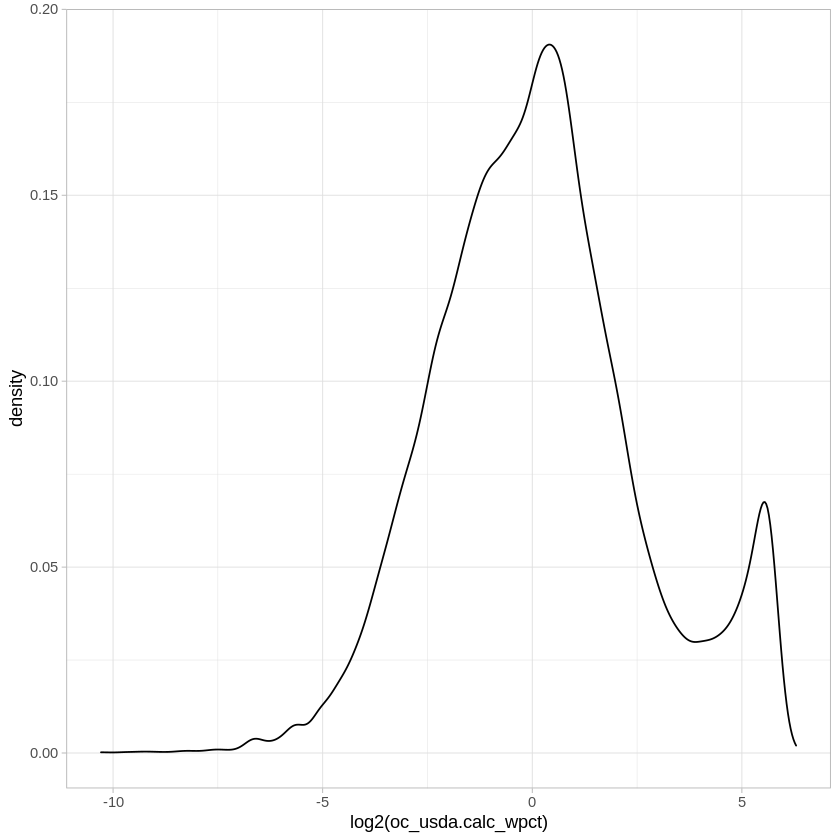

In [82]:
ggplot(kssl.ssl.oc) +
  geom_density(aes(x = log2(oc_usda.calc_wpct))) +
  theme_light()

# Spectral preprocessing

## Subset
Removing equipment model column and taking a subset of 50 samples

In [118]:
set.seed(1993)
kssl.ssl.mir.sample <- kssl.ssl.mir %>%
  sample_n(50) %>%
  select(-mirmodel.code_any_c)
head(kssl.ssl.mir.sample, 5)

id.layer_uuid_c,id.layer_number,600,602,604,606,608,610,612,614,⋯,3982,3984,3986,3988,3990,3992,3994,3996,3998,4000
<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0678ca2eae02d542cc931e81b74de122,1,1733,1737,1741,1744,1745,1746,1747,1748,⋯,532,532,532,532,532,531,531,531,530,530
1c6da1976887787d9bd06a6c7074fba4,1,1700,1706,1712,1719,1727,1734,1740,1744,⋯,290,290,289,289,288,287,286,286,285,284
e6bc95b8991e4452b3d828a84e6f9075,1,1532,1536,1542,1547,1553,1559,1563,1566,⋯,270,270,270,270,269,269,269,268,268,267
29b7a7f004de40d5261e8f18f80567f3,1,1737,1742,1749,1755,1761,1765,1768,1771,⋯,245,245,244,244,243,243,242,242,241,241
7afca3d87754f7d3a0214dbfa8922877,1,1562,1566,1573,1580,1588,1594,1599,1603,⋯,307,307,307,307,306,306,306,305,305,304


Calculating the first derivative (m=1), using a window of 11 cm-1 (w=11), with a previous smoothing of 5 cm-1 (s=5), and and spectral resolution of 2 cm-1 (delta.wav=2, mandatory to calculate the true derivative, not columns derivative)

In [135]:
kssl.ssl.mir.sample.1stDer <- kssl.ssl.mir.sample %>%
  select(-id.layer_uuid_c, -id.layer_number) %>%
  as.matrix() %>%
  gapDer(X = ., m = 1, w = 11, s = 5, delta.wav = 2) %>%
  as_tibble() %>%
  bind_cols(kssl.ssl.mir.sample[,grep("id.layer_uuid_c|id.layer_number", names(kssl.ssl.mir.sample))]) %>%
  select("id.layer_uuid_c", "id.layer_number", everything())
head(kssl.ssl.mir.sample.1stDer, 5)

id.layer_uuid_c,id.layer_number,620,622,624,626,628,630,632,634,⋯,3962,3964,3966,3968,3970,3972,3974,3976,3978,3980
<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0678ca2eae02d542cc931e81b74de122,1,0.60625,0.51875,0.45000,0.37500,0.29375,0.19375,0.06250,-0.07500,⋯,0.02500,0.01250,-8.881784e-16,-0.0125,-0.02500,-0.03750,-0.04375,-0.05000,-0.06250,-0.07500
1c6da1976887787d9bd06a6c7074fba4,1,0.89375,0.56250,0.21875,-0.14375,-0.50000,-0.82500,-1.11875,-1.36875,⋯,-0.26250,-0.26250,-2.687500e-01,-0.2625,-0.26875,-0.26875,-0.28125,-0.28750,-0.30000,-0.30625
e6bc95b8991e4452b3d828a84e6f9075,1,0.99375,0.70000,0.38750,0.06250,-0.26250,-0.56875,-0.83750,-1.05625,⋯,-0.01875,-0.03125,-3.750000e-02,-0.0500,-0.06875,-0.07500,-0.08125,-0.09375,-0.10625,-0.11875
29b7a7f004de40d5261e8f18f80567f3,1,-0.21875,-0.55000,-0.86875,-1.18125,-1.50000,-1.79375,-2.06875,-2.30625,⋯,-0.13750,-0.15000,-1.625000e-01,-0.1750,-0.19375,-0.20000,-0.20625,-0.20625,-0.21875,-0.21875
7afca3d87754f7d3a0214dbfa8922877,1,1.08750,0.78750,0.46875,0.13750,-0.20000,-0.50000,-0.75000,-0.95000,⋯,-0.04375,-0.05000,-5.625000e-02,-0.0625,-0.06875,-0.07500,-0.08125,-0.09375,-0.10625,-0.11250


Preprocessing result

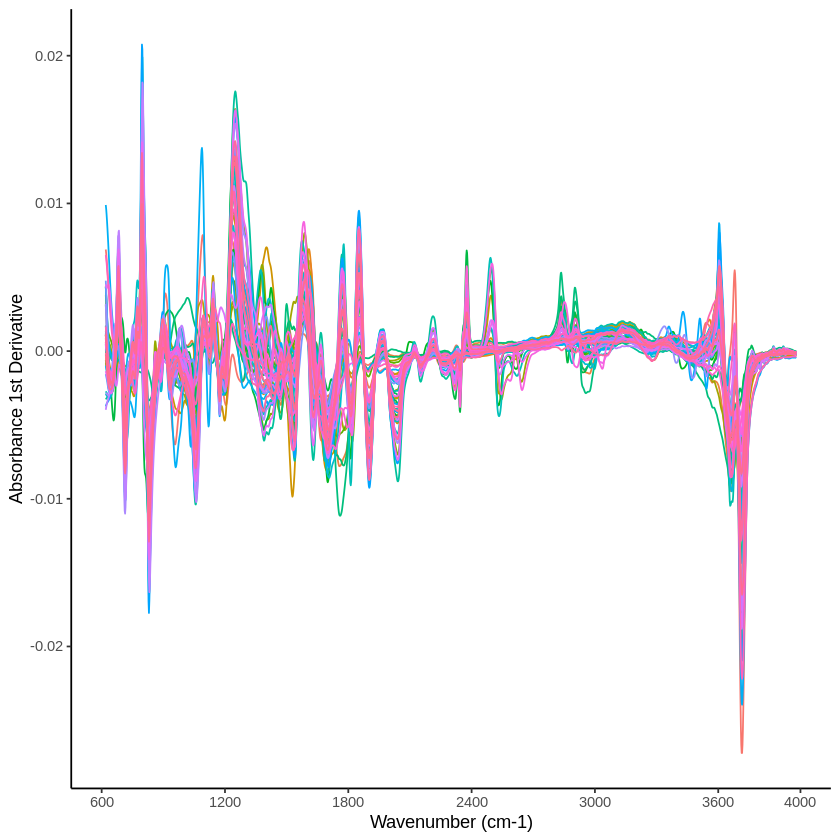

In [137]:
plot_1stDer <- kssl.ssl.mir.sample.1stDer %>%
  pivot_longer(-c(id.layer_uuid_c, id.layer_number), names_to = "wavenumbers", values_to = "absorbance_1stDer") %>%
  mutate(wavenumbers = as.numeric(wavenumbers)) %>%
  ggplot(aes(x = wavenumbers, y = absorbance_1stDer/1000, group = id.layer_uuid_c, color = id.layer_uuid_c)) +
  geom_line(show.legend = F) + labs(x = "Wavenumber (cm-1)", y = "Absorbance 1st Derivative") +
  scale_x_continuous(breaks = c(600, 1200, 1800, 2400, 3000, 3600, 4000)) +
  theme_classic()
plot_1stDer

# Spectral modeling

Using tidymodels workflow

In [151]:
kssl.ssl.calibration <- dplyr::left_join(kssl.ssl.mir.sample.1stDer, kssl.ssl.oc, by = c("id.layer_uuid_c", "id.layer_number")) 

kssl.ssl.oc.formula <- as.formula(paste('oc_usda.calc_wpct', paste(names(kssl.ssl.mir.sample.1stDer)[-c(1:2)], collapse = " + "), sep = " ~ "))

#spectral.recipe <- recipe(kssl.ssl.oc.formula, data = kssl.ssl.calibration)